# Assigment 4

# vector fields in Part 2, 3, 4 are all based on SOFT CONSTRAINED vector field

In [1]:
import math
import numpy as np
import scipy.sparse as sp

import igl
import meshplot as mp

from math import sqrt

In [2]:
v, f = igl.read_triangle_mesh("data/irr4-cyl2.off")
tt, _ = igl.triangle_triangle_adjacency(f)

c = np.loadtxt("data/irr4-cyl2.constraints")
cf = c[:, 0].astype(np.int64)
c = c[:, 1:]
# print(cf)
# print(c)

# 1. Tangent vector fields for scalar field design 
## Soft Constraint

In [3]:
def align_field(V, F, TT, soft_id, soft_value, llambda):
    assert(soft_id[0] > 0)
    assert(soft_id.shape[0] == soft_value.shape[0])

    
    # Edges
    e1 = V[F[:, 1], :] - V[F[:, 0], :]
    e2 = V[F[:, 2], :] - V[F[:, 0], :]

    # Compute the local reference systems for each face, T1, T2
    T1 = e1 / np.linalg.norm(e1, axis=1)[:,None]
        
    T2 =  np.cross(T1, np.cross(T1, e2))
    T2 /= np.linalg.norm(T2, axis=1)[:,None]
  
    # Arrays for the entries of the matrix
    data = []
    ii = []
    jj = []
    
    index = 0
    for f in range(F.shape[0]):
        for ei in range(3): # Loop over the edges
            
            # Look up the opposite face
            g = TT[f, ei]
            
            # If it is a boundary edge, it does not contribute to the energy
            # or avoid to count every edge twice
            if g == -1 or f > g:
                continue
                
            # Compute the complex representation of the common edge
            e  = V[F[f, (ei+1)%3], :] - V[F[f, ei], :]
            
            vef = np.array([np.dot(e, T1[f, :]), np.dot(e, T2[f, :])])
            vef /= np.linalg.norm(vef)
            ef = (vef[0] + vef[1]*1j).conjugate()
            
            veg = np.array([np.dot(e, T1[g, :]), np.dot(e, T2[g, :])])
            veg /= np.linalg.norm(veg)
            eg = (veg[0] + veg[1]*1j).conjugate()
            
            
            # Add the term conj(f)^n*ui - conj(g)^n*uj to the energy matrix
            data.append(ef);  ii.append(index); jj.append(f)
            data.append(-eg); ii.append(index); jj.append(g)

            index += 1
            
    
    sqrtl = sqrt(llambda)
    
    # Convert the constraints into the complex polynomial coefficients and add them as soft constraints
    
    # Rhs of the system
    b = np.zeros(index + soft_id.shape[0], dtype=np.complex)
    
    for ci in range(soft_id.shape[0]):
        f = soft_id[ci]
        v = soft_value[ci, :]
        
        # Project on the local frame
        c = np.dot(v, T1[f, :]) + np.dot(v, T2[f, :])*1j
        
        data.append(sqrtl); ii.append(index); jj.append(f)
        b[index] = c * sqrtl
        
        index += 1
    
    assert(b.shape[0] == index)
    
    
    # Solve the linear system
    A = sp.coo_matrix((data, (ii, jj)), shape=(index, F.shape[0])).asformat("csr")
    u = sp.linalg.spsolve(A.H @ A, A.H @ b)
    R = T1 * u.real[:,None] + T2 * u.imag[:,None]

    return R

In [4]:
def plot_mesh_field(V, F, R, constrain_faces):
    # Highlight in red the constrained faces
    col = np.ones_like(f)
    col[constrain_faces, 1:] = 0
    
    # Scaling of the representative vectors
    avg = igl.avg_edge_length(V, F)/2

    #Plot from face barycenters
    B = igl.barycenter(V, F)

    p = mp.plot(V, F, c=col)
    p.add_lines(B, B + R * avg)
    
    return p

In [5]:
R = align_field(v, f, tt, cf, c, 1e6)
plot_mesh_field(v, f, R, cf)
np.savetxt('data/softconstr_vectors.txt', R, delimiter=' ')

C:\Users\13400\AppData\Local\Temp\ipykernel_20744\1349794068.py:57: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.zeros(index + soft_id.shape[0], dtype=np.complex)
E:\Programs\Anaconoda\envs\py38\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## Hard Constraint

In [6]:
## min ||A*x||, A = [Af, xf], x = [xf, xc], xc is hard constraint
## that is, min || Af*xf + Ac*xc ||
## => Af.H*Af*Xf+Af.H*Ac*xc = 0 
def align_field_hard_constraint(V, F, TT, constr_fids, constr_vals):
    assert(constr_fids.shape[0] > 0) # I think this should be .shape[0] not just [0]
    assert(constr_fids.shape[0] == constr_vals.shape[0])

    
    # Edges
    e1 = V[F[:, 1], :] - V[F[:, 0], :]
    e2 = V[F[:, 2], :] - V[F[:, 0], :]

    # Compute the local reference systems for each face, T1, T2
    T1 = e1 / np.linalg.norm(e1, axis=1)[:,None]
        
    T2 =  np.cross(T1, np.cross(T1, e2))
    T2 /= np.linalg.norm(T2, axis=1)[:,None]
  
    # Arrays for the entries of the matrix
    data = []
    ii = []
    jj = []
    
    index = 0
    for f in range(F.shape[0]):
        for ei in range(3): # Loop over the edges
            
            # Look up the opposite face
            g = TT[f, ei]
            
            # If it is a boundary edge, it does not contribute to the energy
            # or avoid to count every edge twice
            if g == -1 or f > g:
                continue
                
            # Compute the complex representation of the common edge
            e  = V[F[f, (ei+1)%3], :] - V[F[f, ei], :]
            
            vef = np.array([np.dot(e, T1[f, :]), np.dot(e, T2[f, :])])
            vef /= np.linalg.norm(vef)
            ef = (vef[0] + vef[1]*1j).conjugate()
            
            veg = np.array([np.dot(e, T1[g, :]), np.dot(e, T2[g, :])])
            veg /= np.linalg.norm(veg)
            eg = (veg[0] + veg[1]*1j).conjugate()
            
            
            # Add the term conj(f)^n*ui - conj(g)^n*uj to the energy matrix
            data.append(ef);  ii.append(index); jj.append(f)
            data.append(-eg); ii.append(index); jj.append(g)

            index += 1
            
            
    A = sp.coo_matrix((data, (ii, jj)), shape=(index, F.shape[0])).asformat("csr")
    # split A, x according to unknown xf and constants (hard constraints) xc
    fnum = F.shape[0] # number of faces
    constr_fnum = constr_fids.shape[0] # number of constrained faces
    unconstr_fnum = fnum - constr_fnum
    unconstr_fids = []
    for fid in range(fnum):
        if (not (fid in constr_fids)):
            unconstr_fids.append(fid)
            
    # A = [Af, Ac]
    Af = A[:, unconstr_fids]
    Ac = A[:, constr_fids]
    
    # get xc -- convert constraint vectors to complex numbers on coordinates of each face
    xc = np.zeros(constr_fnum, dtype=np.complex)
    for cid in range(constr_fnum):
        fid = constr_fids[cid]
        v = constr_vals[cid] # 3d vector
        c = np.dot(v, T1[fid, :]) + np.dot(v, T2[fid, :])*1j # converted to complex number on this face
        xc[cid] = c
        
    # Solve the linear system
    xf = sp.linalg.spsolve(Af.H @ Af, -1*Af.H @ Ac @ xc)
    # convert to 3-d coordinates (unconstraint vectors)
#     print(T1.shape)
#     print(xf.real[:,None].shape)
    unconstr_vals = T1[unconstr_fids, :] * xf.real[:,None] + T2[unconstr_fids, :] * xf.imag[:,None]
    # vectors of each face
    vectors = np.zeros((fnum, 3))
    vectors[unconstr_fids] = unconstr_vals
    vectors[constr_fids] = constr_vals

    return vectors

In [7]:
vectors_hardconstr = align_field_hard_constraint(v, f, tt, cf, c)
plot_mesh_field(v, f, vectors_hardconstr, cf)
np.savetxt('data/hardconstr_vectors.txt', vectors_hardconstr, delimiter=' ')

C:\Users\13400\AppData\Local\Temp\ipykernel_20744\2741399538.py:70: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xc = np.zeros(constr_fnum, dtype=np.complex)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# 2. Reconstructing a scalar field from a vector field

In [8]:
## min SUM_t(A_t||Del f(p_t) - v_t||^2) to solve scalar field ( a #V-dim vector S)
## solve min||WS-b||^2 where W is 3#F*#V, S is #V*1, b is 3#F*1 (b is vector field)
## not full mark -> split S to s1, s2 where s1 unknown , s2 is 1*1 with any value
## corresponding partitioned matrix W1, W2
## then min||W1s1-(b-W2s2)||^2 -> to solve W1_H@W1@S1-W1_H@(b-W2@S2)=0

# get perpendicular vector of a 3-d vector on a specific face (rotate 90 degree counter clockwise)
def get_perpendicular(vec, vec2):
    # vertical to this face
    plane_vertical = np.cross(vec2, vec)
    # normalize it
    plane_vert_normed = plane_vertical / np.linalg.norm(plane_vertical)
    return np.cross(vec, plane_vert_normed)

# print(get_perpendicular([1, -3, 0], [2,-3,0]))

def construct_scalar_field(vertices, faces, vectors):
    vnum = vertices.shape[0]
    fnum = faces.shape[0]
    # area of each face
    areas = 0.5 * igl.doublearea(vertices, faces)
#     print("areas shape:", areas.shape)
#     print(areas)
    sqrt_areas = np.sqrt(areas)
    
    # build matrix W (sparse matrix)
    W_data = []
    W_rows = []
    W_cols = []
    for fid in range(fnum):
        # 3 rows (3 terms) for each face
        sqrt_area = sqrt_areas[fid]
        vi_id = faces[fid][0]
        vj_id = faces[fid][1]
        vk_id = faces[fid][2]
        vi_coord = vertices[vi_id, :]
        vj_coord = vertices[vj_id, :]
        vk_coord = vertices[vk_id, :]
        e1 = vj_coord - vi_coord
        e2 = vk_coord - vj_coord
        e3 = vi_coord - vk_coord
        # perpendicular
        e1_per = get_perpendicular(e1, -1*e3)
        e3_per = get_perpendicular(e3, -1*e2)
        eadd_per = e1_per + e3_per
        for dim_i in range(3):
            W_data.append(-0.5 / sqrt_area * eadd_per[dim_i])
            W_rows.append(3*fid + dim_i)
            W_cols.append(vi_id)
            W_data.append(0.5 / sqrt_area * e3_per[dim_i])
            W_rows.append(3*fid + dim_i)
            W_cols.append(vj_id)
            W_data.append(0.5 / sqrt_area * e1_per[dim_i])
            W_rows.append(3*fid + dim_i)
            W_cols.append(vk_id)
    W = sp.coo_matrix((W_data, (W_rows, W_cols)), shape=(3*fnum, vnum)).asformat("csr")
    W1 = W[:, :vnum - 1]
    W2 = W[:, [vnum - 1]]
#     print("W2 shape: ", W2.shape)
    
    # build b (vector fields weighted by sqrt area)
    b = np.zeros(3*fnum)
    for fid in range(fnum):
        sqrt_area = sqrt_areas[fid]
        vec = vectors[fid, :]
        for dim_i in range(3):
            b[3*fid + dim_i] = sqrt_area * vec[dim_i]
    
    # assign random value to s2
    s2 = np.array([0.0])
    
    # solve s1 (unknown scalar array)
    s1 = sp.linalg.spsolve(W1.H @ W1, W1.H @ (b - W2@s2))
    
    return np.concatenate((s1,s2))

def plot_vectors_and_scalars(V, F, vectors, scalars):
    
    # Scaling of the representative vectors
    avg = igl.avg_edge_length(V, F)/2

    #Plot from face barycenters
    B = igl.barycenter(V, F)

    p = mp.plot(V, F, c=scalars)
    p.add_lines(B, B + vectors * avg)
    
    return p

In [9]:
# scalar field value on each vertex (from vector field of soft constraints)
scalars = construct_scalar_field(v, f, R)
plot_vectors_and_scalars(v, f, R, scalars)
np.savetxt('data/softconstr_reconstr_scalars.txt', scalars, delimiter=' ')

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

## Poisson reconstruction error

### plot error vectors with scalar field

In [10]:
## reconstr_error on each face
def plot_poisson_reconstr_error(vertices, faces, vectors, scalars):
    grad_op = igl.grad(vertices, faces)
    scalar_grad_flat = grad_op@scalars
    scalar_grad = scalar_grad_flat.reshape((faces.shape[0], 3))
    #Plot from face barycenters
    B = igl.barycenter(vertices, faces)
    p = mp.plot(vertices, faces, c=scalars)
    avg = igl.avg_edge_length(vertices, faces)/2
    p.add_lines(B, B + (scalar_grad - vectors)*avg*0.5)
    
plot_poisson_reconstr_error(v, f, R, scalars)    

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### plot error vector magnitudes

In [11]:
## reconstr_error on each face
def plot_poisson_error_magnitude(vertices, faces, vectors, scalars):
    grad_op = igl.grad(vertices, faces)
    scalar_grad_flat = grad_op@scalars
    scalar_grad = scalar_grad_flat.reshape((faces.shape[0], 3))
    err_vectors = scalar_grad - vectors
    err_norms = np.linalg.norm(err_vectors, axis = 1)
    print(err_vectors.shape)
    p = mp.plot(vertices, faces, err_norms)
    
plot_poisson_error_magnitude(v, f, R, scalars)    

(756, 3)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

# 3. Harmonic and LSCM Parameterizations

## Gradient

In [12]:
# gradient of hamonic v(x, y, z) on camel
def plot_gradient(vertices, faces, scalars):
    grad_op = igl.grad(vertices, faces)
    scalar_grad_flat = grad_op@scalars
    scalar_grad = scalar_grad_flat.reshape((faces.shape[0], 3))
    # Scaling of the representative vectors
    avg = igl.avg_edge_length(vertices, faces)/2

    #Plot from face barycenters
    B = igl.barycenter(vertices, faces)

    p = mp.plot(vertices, faces, scalars)
    p.add_lines(B, B + scalar_grad * avg * 0.5)

## Harmonic parametrization

In [13]:
v, f  = igl.read_triangle_mesh("data/camel_head.off")
## Find the open boundary
bnd = igl.boundary_loop(f)

## Map the boundary to a circle, preserving edge proportions
bnd_uv = igl.map_vertices_to_circle(v, bnd)
# print(bnd_uv)
## Harmonic parametrization for the internal vertices
uv = igl.harmonic_weights(v, f, bnd, bnd_uv, 1)
# print(uv.shape)
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])
# print(v_p.shape)

# p = mp.subplot(v, f, uv = uv,s=[1, 2, 0])
p = mp.subplot(v, f, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
mp.subplot(v_p, f, shading={"wireframe": True, "flat": False}, s=[1, 2, 1], data=p)
# mp.subplot(v_p, f, uv=uv, shading={"wireframe": True, "flat": False}, s=[1, 2, 1], data=p)

In [14]:
# gradient of v
plot_gradient(v, f, uv[:, 1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

## LSCM (Least squares conformal maps)

In [15]:

# Fix two points on the boundary
b = np.array([2, 1])

bnd = igl.boundary_loop(f)
b[0] = bnd[0]
b[1] = bnd[int(bnd.size / 2)]

bc = np.array([[0.0, 0.0], [1.0, 0.0]])

# LSCM parametrization
_, uv = igl.lscm(v, f, b, bc)

p = mp.subplot(v, f, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
# mp.subplot(uv, f, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 1], data=p)
mp.subplot(uv, f, shading={"wireframe": True, "flat": False}, s=[1, 2, 1], data=p)


In [16]:
# gradient of v
plot_gradient(v, f, uv[:, 1])

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(1.9967555…

# 4. Editing a parameterization with vector fields

## Editing the parameterization

In [17]:
v, f = igl.read_triangle_mesh("data/irr4-cyl2.off")
tt, _ = igl.triangle_triangle_adjacency(f)

c = np.loadtxt("data/irr4-cyl2.constraints")
cf = c[:, 0].astype(np.int64)
c = c[:, 1:]

## harmonic parameterization
## Find the open boundary
bnd = igl.boundary_loop(f)
## Map the boundary to a circle, preserving edge proportions
bnd_uv = igl.map_vertices_to_circle(v, bnd)
# print(bnd_uv)
## Harmonic parametrization for the internal vertices
uv = igl.harmonic_weights(v, f, bnd, bnd_uv, 1)
v_p = np.hstack([uv, np.zeros((uv.shape[0],1))])

p = mp.subplot(v, f, uv=uv, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
mp.subplot(v_p, f, shading={"wireframe": True, "flat": False}, s=[1, 2, 1], data=p)

In [18]:
# Highlight in blue the constrained faces
col = np.ones_like(f)
col[cf, :2] = 0
# Scaling of the representative vectors
avg = igl.avg_edge_length(v, f)/2
#Plot from face barycenters
B = igl.barycenter(v, f)
B = B[cf]

p = mp.plot(v, f, c=col, shading={"wireframe": True})
p.add_lines(B, B + c * avg)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1

In [19]:
# use soft constraint to build vector fields
vectors_softconstr = align_field(v, f, tt, cf, c, 1e6)
plot_mesh_field(v, f, vectors_softconstr, cf)

C:\Users\13400\AppData\Local\Temp\ipykernel_20744\1349794068.py:57: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b = np.zeros(index + soft_id.shape[0], dtype=np.complex)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [20]:
scalars = construct_scalar_field(v, f, vectors_softconstr)

In [21]:
# scalar field constructed from the vector field
plot_vectors_and_scalars(v, f, vectors_softconstr, scalars)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [22]:
# change v(x,y,z) to the scalar field in parameterization
a0 = uv[:, 0].reshape((uv.shape[0],1))
a1 = scalars.reshape((scalars.shape[0],1))
uv_edited = np.hstack([a0,a1])
# print(uv_edited.shape)
v_p = np.hstack([uv_edited, np.zeros((uv_edited.shape[0],1))])
p = mp.subplot(v, f, uv=uv_edited, shading={"wireframe": False, "flat": False}, s=[1, 2, 0])
mp.subplot(v_p, f, shading={"wireframe": True, "flat": False}, s=[1, 2, 1], data=p)
# Scaling of the representative vectors
avg = igl.avg_edge_length(v, f)/2
#Plot from face barycenters
B = igl.barycenter(v, f)
p.rows[0][0].add_lines(B, B + vectors_softconstr*0.1)

1

## Detecting problems with the parameterization

In [23]:
# if flip over, the direction of 3 points of a face is flipped
# face normals on uv plane
uv_normals = igl.per_face_normals(v_p, f, np.array([1.0,1.0,1.0]))
flipped_fids = []
for fid in range(uv_normals.shape[0]):
    if uv_normals[fid][2] > 0:
        flipped_fids.append(fid)
print("flipped faces num: "+str(len(flipped_fids)))
np.savetxt('data/flipped_face_indices.txt', flipped_fids, fmt='%i', delimiter=' ')
# print(uv_normals)

flipped faces num: 84


In [24]:
# Highlight flipped faces in green
colors = np.ones_like(f)
colors[flipped_fids, 0] = 0
colors[flipped_fids, 2] = 0
p = mp.subplot(v, f, c = colors,shading={"wireframe": True, "flat": True}, s=[1, 2, 0])
mp.subplot(v_p, f, c = colors, shading={"wireframe": True, "flat": True}, s=[1, 2, 1], data=p)

# Assign 2 Optional 1 - Normal Constraints

In [25]:
import numpy as np
import igl
import meshplot as mp
import math
import random
import matplotlib.pyplot as plt

In [26]:
# create 2-D dataset
# def create_2d_boundary():
#     vnum = 200
#     radius = 1.0
#     dtheta = 2*math.pi/vnum
#     rx = [0.5 + random.uniform(0,1)/2 for i in range(vnum)]
#     vertices_a = np.zeros((vnum, 2))
#     vertices = np.zeros((vnum, 2))
#     for vi in range(vnum):
#         vertices_a[vi][0] = rx[vi]*math.cos(dtheta*vi)
#         vertices_a[vi][1] = rx[vi]*math.sin(dtheta*vi)
#     window_len = 5
#     for vi in range(vnum):
#         x = 0
#         y = 0
#         for j in range(window_len):
#             x += vertices_a[(vi+j)%vnum][0]
#             y += vertices_a[(vi+j)%vnum][1]
#         vertices[vi][0] = x/window_len
#         vertices[vi][1] = y/window_len
#     plt.plot(vertices[:,0], vertices[:, 1])
#     np.savetxt('data/2dboundary.txt', vertices, delimiter=' ')
#     np.savetxt('data/2dnorm.txt', vertices_a, delimiter=' ')

# create_2d_boundary()

# vertices = np.loadtxt("data/2dboundary.txt")
# norms = np.loadtxt("data/2dnorm.txt")
# vertices, faces = igl.read_triangle_mesh("data/cat.off")
# vertices = vertices/10
# normals = igl.per_vertex_normals(vertices, faces)
# vertices = vertices[:, :2]
# normals = normals[:, :2]
# vnum = vertices.shape[0]
# # print(vnum)
# # print(normals.shape)
# plt.plot(vertices[:,0], vertices[:, 1], marker = 'o' ,linestyle="")
# max_coordinate = np.max(vertices, axis = 0)
# min_coordinate = np.min(vertices, axis = 0)
# diagonal_len = np.linalg.norm(max_coordinate - min_coordinate)
# # print(diagonal_len)

## Previous Constraints

In [27]:
# # return id of closed point
# def find_closed_point(point, points):
#     # distances of each point
#     distances = np.linalg.norm(points - point, axis = 1)
#     return np.argmin(distances)

# # get appropriate eps for this point
# def update_eps(_eps, _x_id, _x_coord, _norm):
#     x_eps = _x_coord + _norm * _eps
#     if(find_closed_point(x_eps, vertices) == _x_id):
#         return _eps
#     else:
#         return update_eps(_eps/2, _x_id, _x_coord, _norm)

# # initial eps
# eps = 0.01 * diagonal_len
# # print(eps)

# # get v+ and v- for each vertex v
# constraint_v_coord_arr = np.zeros((3*vnum, 2), dtype = np.float64)
# constraint_fval_arr = np.zeros(3*vnum, dtype = np.float64)
# constraint_color_arr = np.zeros((3*vnum, 3), dtype = np.float64) #RGB
# for v_id in range(vnum):
#     coord = vertices[v_id]
#     normal = normals[v_id]
#     constraint_v_coord_arr[3*v_id] = coord
#     constraint_fval_arr[3*v_id] = 0.0
#     constraint_color_arr[3*v_id] = [0.0, 0.0, 1.0]
#     # for v+
#     eps = update_eps(eps, v_id, coord, normal)
#     constraint_v_coord_arr[3*v_id + 1] = coord + eps * normal
#     constraint_fval_arr[3*v_id + 1] = eps
#     constraint_color_arr[3*v_id + 1] = [1.0, 0.0, 0.0]
#     # for v-
#     eps = update_eps(eps, v_id, coord, -normal)
#     constraint_v_coord_arr[3*v_id + 2] = coord - eps * normal
#     constraint_fval_arr[3*v_id + 2] = -eps
#     constraint_color_arr[3*v_id + 2] = [0.0, 1.0, 0.0]

# # plot constraint points
# constrs_3d = np.hstack([constraint_v_coord_arr, np.zeros((3*vnum,1))])
# mp.plot(constrs_3d, c = constraint_color_arr, shading={"point_size":8})

In [28]:

vertices, faces = igl.read_triangle_mesh("data/cat.off")
vertices /= 10
normals = igl.per_vertex_normals(vertices, faces)
vnum = vertices.shape[0]
max_coordinate = np.max(vertices, axis = 0)
min_coordinate = np.min(vertices, axis = 0)
diagonal_len = igl.bounding_box_diagonal(vertices)
mp.plot(vertices, shading={"point_size": 8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

In [29]:
mmin =  min_coordinate - 0.05 * diagonal_len
mmax =  max_coordinate + 0.05 * diagonal_len
delta = mmax-mmin

dims = [25, 25, 25]
nx = dims[0]
ny = dims[1]
nz = dims[2]

deltax = delta[0]/(nx-1)
deltay = delta[1]/(ny-1)
deltaz = delta[2]/(nz-1)

# cube triple to cube id
cube_mapping = -np.ones((nx-1, ny-1, nz-1), dtype=np.int64)

index = 0
for i in range(nx-1):
    for j in range(ny-1):
        for k in range(nz-1):
            cube_mapping[i, j, k] = index
            index += 1

cube_to_vertice_ids = []
for i in range((nx-1)*(ny-1)*(nz-1)):
    cube_to_vertice_ids.append([])

for v_id in range(vnum):
    v_coord = vertices[v_id]
    cube_x = int((v_coord[0] - mmin[0])/deltax)
    cube_y = int((v_coord[1] - mmin[1])/deltay)
    cube_z = int((v_coord[2] - mmin[2])/deltaz)
    cube_id = cube_mapping[cube_x, cube_y, cube_z]
    cube_to_vertice_ids[cube_id].append(v_id)
    
d_triples = []
a = [-1, 0, 1]
for i in range(3):
    for j in range(3):
        for k in range(3):
            d_triples.append([a[i], a[j], a[k]])
              
# new find_closed_point of constraints
def find_closed_point(_point, points = None):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_z = int((_point[2] - mmin[2])/deltaz)
    cube_triple = [cube_x, cube_y, cube_z]

    weight = 0
    while(len(v_ids_probe) == 0):
        weight += 1
        for i in range(27):
            tmp_cube_triple = np.array(cube_triple) + np.array(d_triples[i]) * weight
            # boundary 
            if(np.min(tmp_cube_triple) >= 0 and np.min(np.array([nx-1, ny-1, nz-1])-np.array(tmp_cube_triple)) >=0):
                tmp_cube_id = cube_mapping[tmp_cube_triple[0]][tmp_cube_triple[1]][tmp_cube_triple[2]]
                for v_id in cube_to_vertice_ids[tmp_cube_id]:
                    v_ids_probe.append(v_id)
    points = vertices[v_ids_probe]
    distances = np.linalg.norm(points - _point, axis = 1)
    i = np.argmin(distances)
    return v_ids_probe[i]

# new get_close_points_ids for MLS
def get_close_points_ids(_point, _points, _h):
    v_ids_probe = []
    cube_x = int((_point[0] - mmin[0])/deltax)
    cube_y = int((_point[1] - mmin[1])/deltay)
    cube_z = int((_point[2] - mmin[2])/deltaz)
    cube_triple = [cube_x, cube_y, cube_z]
    dx = int(_h/deltax)
    dy = int(_h/deltay)
    dz = int(_h/deltaz)
    for i in range(max(cube_x - dx, 0), min(cube_x + dx, nx -1)):
        for j in range(max(cube_y - dy, 0), min(cube_y + dy, ny -1)):
            for k in range(max(cube_z - dz, 0), min(cube_z + dz, nz -1)):
                tmp_cube_id = cube_mapping[i,j,k]
                for v_id in cube_to_vertice_ids[tmp_cube_id]:
                    v_ids_probe.append(v_id)
    return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()

In [30]:
# get appropriate eps for this point
def update_eps(_eps, _x_id, _x_coord, _norm):
    x_eps = _x_coord + _norm * _eps
    if(find_closed_point(x_eps, vertices) == _x_id):
        return _eps
    else:
        return update_eps(_eps/2, _x_id, _x_coord, _norm)

# initial eps
eps = 0.01 * diagonal_len
# print(eps)

# get v+ and v- for each vertex v
constraint_v_coord_arr = np.zeros((3*vnum, 3), dtype = np.float64)
constraint_fval_arr = np.zeros(3*vnum, dtype = np.float64)
constraint_color_arr = np.zeros((3*vnum, 3), dtype = np.float64) #RGB
for v_id in range(vnum):
    coord = vertices[v_id]
    norm = normals[v_id]
    constraint_v_coord_arr[3*v_id] = coord
    constraint_fval_arr[3*v_id] = 0.0
    constraint_color_arr[3*v_id] = [0.0, 0.0, 1.0]
    # for v+
    eps = update_eps(eps, v_id, coord, norm)
    constraint_v_coord_arr[3*v_id + 1] = coord + eps * norm
    constraint_fval_arr[3*v_id + 1] = eps
    constraint_color_arr[3*v_id + 1] = [1.0, 0.0, 0.0]
    # for v-
    eps = update_eps(eps, v_id, coord, -norm)
    constraint_v_coord_arr[3*v_id + 2] = coord - eps * norm
    constraint_fval_arr[3*v_id + 2] = -eps
    constraint_color_arr[3*v_id + 2] = [0.0, 1.0, 0.0]

# plot constraint points
mp.plot(constraint_v_coord_arr, c = constraint_color_arr, shading={"point_size": 8})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0120944…

## Normal Constraints

In [31]:
# calculate normal constraints of close points according to point x
def gen_normal_constr_vals(x, constr_coords, prev_constr_vals, close_constr_vids):
    close_vnum = len(close_constr_vids)
    normal_constr_vals = np.zeros(close_vnum)
    for i in range(close_vnum):
        constr_vi = close_constr_vids[i]
        raw_vi = constr_vi//3
        normal = normals[raw_vi]
        constr_coord = constr_coords[constr_vi]
        normal_constr_vals[i] = prev_constr_vals[constr_vi] + np.dot(x-constr_coord, normal)
    return normal_constr_vals

## MLS

In [32]:
## for 2D
# def build_grids(n, mmin, mmax):
#     nx = n[0]
#     ny = n[1]
#     delta = mmax-mmin
#     deltax = delta[0]/(nx-1)
#     deltay = delta[1]/(ny-1)
#     grids = np.zeros((nx*ny, 2))
#     index = 0
#     for i in range(nx):
#         for j in range(ny):
#             grids[index, :] = [i*deltax, j*deltay]
#             index += 1
#     return grids

# poly_degree = 2
# def get_poly_terms(_coord):
#     x = _coord[0]
#     y = _coord[1]
#     if(poly_degree == 0):
#         return np.array([1.0])
#     elif(poly_degree == 1):
#         return np.array([1.0, x, y])
#     elif(poly_degree == 2):
#         return np.array([1.0, x, y, x*x, y*y, x*y])
#     print("error: incorrect poly_degree")
#     return None

# poly_coeff_num = 0
# if(poly_degree == 0):
#     poly_coeff_num = 1
# elif(poly_degree == 1):
#     poly_coeff_num = 3
# elif(poly_degree == 2):
#     poly_coeff_num = 6

# # wendland weight function
# wendland_h = 0.08
# def wendland(_r):
#     return pow(1 - _r/wendland_h, 4)*(4*_r/wendland_h + 1)


# mmin =  min_coordinate - 0.05 * diagonal_len
# mmax =  max_coordinate + 0.05 * diagonal_len
# delta = mmax-mmin
# n=[100, 100]
# nx = n[0]
# ny = n[1]

# deltax = delta[0]/(nx-1)
# deltay = delta[1]/(ny-1)

# # cube triple to cube id
# cube_mapping = -np.ones((nx-1, ny-1), dtype=np.int64)

# index = 0
# for i in range(nx-1):
#     for j in range(ny-1):
#         cube_mapping[i, j] = index
#         index += 1

# cube_to_vertice_ids = []
# for i in range((nx-1)*(ny-1)):
#     cube_to_vertice_ids.append([])

# for v_id in range(vnum):
#     v_coord = vertices[v_id]
#     cube_x = int((v_coord[0] - mmin[0])/deltax)
#     cube_y = int((v_coord[1] - mmin[1])/deltay)
#     cube_id = cube_mapping[cube_x, cube_y]
#     cube_to_vertice_ids[cube_id].append(v_id)
    
# d_triples = []
# a = [-1, 0, 1]
# for i in range(3):
#     for j in range(3):
#             d_triples.append([a[i], a[j]])
              
# # new find_closed_point of constraints
# def find_closed_point(_point, points = None):
#     v_ids_probe = []
#     cube_x = int((_point[0] - mmin[0])/deltax)
#     cube_y = int((_point[1] - mmin[1])/deltay)
#     cube_triple = [cube_x, cube_y]

#     weight = 0
#     while(len(v_ids_probe) == 0):
#         weight += 1
#         for i in range(9):
#             tmp_cube_triple = np.array(cube_triple) + np.array(d_triples[i]) * weight
#             # boundary 
#             if(np.min(tmp_cube_triple) >= 0 and np.min(np.array([nx-1, ny-1])-np.array(tmp_cube_triple)) >=0):
#                 tmp_cube_id = cube_mapping[tmp_cube_triple[0]][tmp_cube_triple[1]]
#                 for v_id in cube_to_vertice_ids[tmp_cube_id]:
#                     v_ids_probe.append(v_id)
#     points = vertices[v_ids_probe]
#     distances = np.linalg.norm(points - _point, axis = 1)
#     i = np.argmin(distances)
#     return v_ids_probe[i]

# # new get_close_points_ids for MLS
# def get_close_points_ids(_point, _points, _h):
#     v_ids_probe = []
#     cube_x = int((_point[0] - mmin[0])/deltax)
#     cube_y = int((_point[1] - mmin[1])/deltay)
#     cube_triple = [cube_x, cube_y]
#     dx = int(_h/deltax)
#     dy = int(_h/deltay)
#     for i in range(max(cube_x - dx, 0), min(cube_x + dx, nx -1)):
#         for j in range(max(cube_y - dy, 0), min(cube_y + dy, ny -1)):
#             tmp_cube_id = cube_mapping[i,j]
#             for v_id in cube_to_vertice_ids[tmp_cube_id]:
#                 v_ids_probe.append(v_id)
#     return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()


# def calc_grid(grid_vertices, constraint_v_coord_arr, constraint_fval_arr):
#     grid_v_num = grid_vertices.shape[0]
#     grid_v_fval_arr = np.zeros(grid_v_num)   
#     for i in range(grid_v_num):
#         # each grid vertex
#         close_points = get_close_points_ids(grid_vertices[i], constraint_v_coord_arr, wendland_h)
#         if (len(close_points) < poly_coeff_num*2):
#             grid_v_fval_arr[i] = 50 # any positive value, means outside
#         else:
#             B = np.zeros((len(close_points), poly_coeff_num))
#             DIAG = np.zeros((len(close_points), len(close_points)))
#             b_arr = np.zeros((len(close_points), 1))    
#             for j in range(len(close_points)):
#                 r = np.linalg.norm(grid_vertices[i] - constraint_v_coord_arr[close_points[j]])
#                 DIAG[j][j] = wendland(r)
#                 B[j] = get_poly_terms(constraint_v_coord_arr[close_points[j]])
#                 b_arr[j] = constraint_fval_arr[close_points[j]]
#             A = np.dot(np.dot(np.transpose(B), DIAG), B)
#             C = np.dot(np.dot(np.transpose(B), DIAG), b_arr)
#             X = np.linalg.solve(A, C)
#             for j in range(len(close_points)):
#                 grid_v_fval_arr[i] += np.dot(B[j], X)
#     ind = np.zeros_like(grid_v_fval_arr)
#     ind[grid_v_fval_arr >= 0] = 1
#     ind[grid_v_fval_arr < 0] = -1
#     mp.plot(grid_vertices, c=ind, shading={"point_size": 0.05,"width": 800, "height": 800})

# grid_vertices = build_grids(n, min_coordinate, max_coordinate)
# calc_grid(grid_vertices, constraint_v_coord_arr, constraint_fval_arr)

# Utility function to generate a tet grid
# n is a 3-tuple with the number of cell in every direction
# mmin/mmax are the grid bounding box corners

def tet_grid(n, mmin, mmax):
    nx = n[0]
    ny = n[1]
    nz = n[2]
    
    delta = mmax-mmin
    
    deltax = delta[0]/(nx-1)
    deltay = delta[1]/(ny-1)
    deltaz = delta[2]/(nz-1)
    
    T = np.zeros(((nx-1)*(ny-1)*(nz-1)*6, 4), dtype=np.int64)
    V = np.zeros((nx*ny*nz, 3))

    mapping = -np.ones((nx, ny, nz), dtype=np.int64)


    index = 0
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                mapping[i, j, k] = index
                V[index, :] = [i*deltax, j*deltay, k*deltaz]
                index += 1
    assert(index == V.shape[0])
    
    tets = np.array([
        [0,1,3,4],
        [5,2,6,7],
        [4,1,5,3],
        [4,3,7,5],
        [3,1,5,2],
        [2,3,7,5]
    ])
    
    index = 0
    for i in range(nx-1):
        for j in range(ny-1):
            for k in range(nz-1):
                indices = [
                    (i,   j,   k),
                    (i+1, j,   k),
                    (i+1, j+1, k),
                    (i,   j+1, k),

                    (i,   j,   k+1),
                    (i+1, j,   k+1),
                    (i+1, j+1, k+1),
                    (i,   j+1, k+1),
                ]
                
                for t in range(tets.shape[0]):
                    tmp = [mapping[indices[ii]] for ii in tets[t, :]]
                    T[index, :]=tmp
                    index += 1
                    
    assert(index == T.shape[0])
    
    V += mmin
    return V, T

# Generate grid n x n x n
n = 25
grid_vertices, T = tet_grid((n, n, n), min_coordinate - 0.05 * diagonal_len, max_coordinate + 0.05 * diagonal_len)

grid_v_num = grid_vertices.shape[0]
# print("grid_v_num: ", grid_v_num)
wendland_h = 25 # wendlandRadius
poly_degree = 0
poly_coeff_num = 0
if(poly_degree == 0):
    poly_coeff_num = 1
elif(poly_degree == 1):
    poly_coeff_num = 4
elif(poly_degree == 2):
    poly_coeff_num = 10
print("poly_coeff_num: ", poly_coeff_num)

# wendland weight function
def wendland(_r):
    return pow(1 - _r/wendland_h, 4)*(4*_r/wendland_h + 1)

# select constraint point ids for each grid vertex
def get_close_points_ids(_point, _points, _h):
    return np.argwhere(np.linalg.norm(_points - _point, axis = 1) < _h).ravel()

# get_close_points_ids([1,1,1], constraint_v_coord_arr, 10)

def get_poly_terms(_coord):
    x = _coord[0]
    y = _coord[1]
    z = _coord[2]
    if(poly_degree == 0):
        return np.array([1.0])
    elif(poly_degree == 1):
        return np.array([1.0, x, y, z])
    elif(poly_degree == 2):
        return np.array([1.0, x, y, z, x*x, y*y, z*z, x*y, y*z, z*x])
    print("error: incorrect poly_degree")
    return None

def grid_MLS(grid_vertices, constraint_v_coord_arr, constraint_fval_arr):
    grid_v_num = grid_vertices.shape[0]
    grid_v_fval_arr = np.zeros(grid_v_num)   
    for i in range(grid_v_num):
        # each grid vertex
        close_points = get_close_points_ids(grid_vertices[i], constraint_v_coord_arr, wendland_h)
        if (len(close_points) < poly_coeff_num*2):
            grid_v_fval_arr[i] = 50 # any positive value, means outside
        else:
            B = np.zeros((len(close_points), poly_coeff_num))
            DIAG = np.zeros((len(close_points), len(close_points)))
            b_arr = np.zeros((len(close_points), 1))    
            for j in range(len(close_points)):
                r = np.linalg.norm(grid_vertices[i] - constraint_v_coord_arr[close_points[j]])
                DIAG[j][j] = wendland(r)
                B[j] = get_poly_terms(constraint_v_coord_arr[close_points[j]])
                b_arr[j] = constraint_fval_arr[close_points[j]]
            A = np.dot(np.dot(np.transpose(B), DIAG), B)
            C = np.dot(np.dot(np.transpose(B), DIAG), b_arr)
            X = np.linalg.solve(A, C)
            for j in range(len(close_points)):
                grid_v_fval_arr[i] += np.dot(B[j], X)
    return grid_v_fval_arr

poly_coeff_num:  1


## MLS for previous constraints

In [33]:
## wait for the computation
grid_v_fval_arr = grid_MLS(grid_vertices, constraint_v_coord_arr, constraint_fval_arr)

### 3D

In [34]:
ind = np.zeros_like(grid_v_fval_arr)
ind[grid_v_fval_arr >= 0] = 1
ind[grid_v_fval_arr < 0] = -1
mp.plot(grid_vertices, c=ind, shading={"point_size": 8,"width": 800, "height": 800})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

### 2D (a horizonal slice) 

In [35]:
# mp.plot(grid_vertices, c=ind, shading={"point_size": 8,"width": 800, "height": 800})
def plot_slice(grid_vertices, grid_v_fval_arr, slice_zid):
# slice_zid should be 0 to n-1
    plane = grid_vertices.reshape((n,n,n,3))[:,:,slice_zid,:].reshape([n*n,3])
    val_plane = grid_v_fval_arr.reshape((n,n,n))[:,:,slice_zid].ravel()
    val_plane = val_plane/np.max(val_plane)
    # ind_plane = ind.reshape((n,n,n))[:,:,0].ravel()
    colors_plane = np.zeros((n*n,3))
    for i in range(n*n):
        if(val_plane[i]>0):
            colors_plane[i][0] = 1
        else:
            colors_plane[i][2] = 1
    alphas_plane = np.absolute(val_plane)
    alphas_plane = alphas_plane/np.max(alphas_plane)
    # print(colors_plane)
    # mp.plot(plane, c=colors_plane, shading={"point_size": 8,"width": 800, "height": 800})
    plt.scatter(plane[:,0], plane[:,1],c=colors_plane, alpha = alphas_plane)

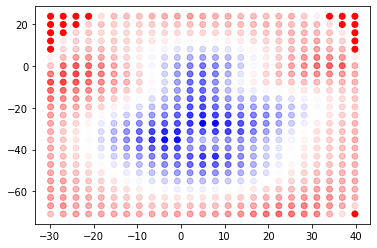

In [36]:
plot_slice(grid_vertices, grid_v_fval_arr, 0)

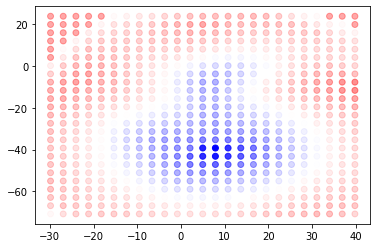

In [37]:
plot_slice(grid_vertices, grid_v_fval_arr, 5)

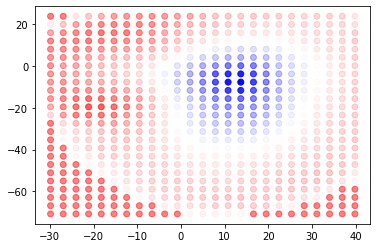

In [38]:
plot_slice(grid_vertices, grid_v_fval_arr, 14)

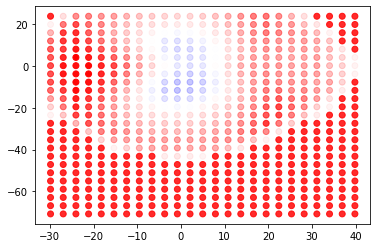

In [39]:
plot_slice(grid_vertices, grid_v_fval_arr, 22)

## MLS for normal constraints

In [40]:
def grid_MLS_normal_constr(grid_vertices, constraint_v_coord_arr, constraint_fval_arr):
    grid_v_num = grid_vertices.shape[0]
    grid_v_fval_arr = np.zeros(grid_v_num)   
    for i in range(grid_v_num):
        # each grid vertex
        close_points = get_close_points_ids(grid_vertices[i], constraint_v_coord_arr, wendland_h)
#         print(close_points)
        # normal constraint values
        normal_constr_vals = gen_normal_constr_vals(grid_vertices[i], constraint_v_coord_arr, constraint_fval_arr, close_points)
        if (len(close_points) < poly_coeff_num*2):
            grid_v_fval_arr[i] = 50 # any positive value, means outside
        else:
            B = np.zeros((len(close_points), poly_coeff_num))
            DIAG = np.zeros((len(close_points), len(close_points)))
            b_arr = np.zeros((len(close_points), 1))    
            for j in range(len(close_points)):
                r = np.linalg.norm(grid_vertices[i] - constraint_v_coord_arr[close_points[j]])
                DIAG[j][j] = wendland(r)
                B[j] = get_poly_terms(constraint_v_coord_arr[close_points[j]])
                b_arr[j] = normal_constr_vals[j]
            A = np.dot(np.dot(np.transpose(B), DIAG), B)
            C = np.dot(np.dot(np.transpose(B), DIAG), b_arr)
            X = np.linalg.solve(A, C)
            for j in range(len(close_points)):
                grid_v_fval_arr[i] += np.dot(B[j], X)
    return grid_v_fval_arr

In [41]:
# wait for the computation
grid_v_fval_arr = grid_MLS_normal_constr(grid_vertices, constraint_v_coord_arr, constraint_fval_arr)

### 3D

In [42]:
ind = np.zeros_like(grid_v_fval_arr)
ind[grid_v_fval_arr >= 0] = 1
ind[grid_v_fval_arr < 0] = -1
mp.plot(grid_vertices, c=ind, shading={"point_size": 8,"width": 800, "height": 800})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…

### 2D (a horizonal slice) 

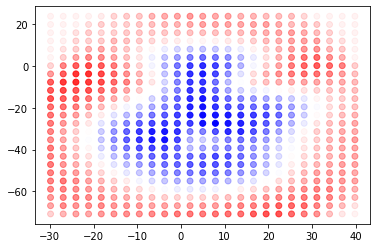

In [43]:
plot_slice(grid_vertices, grid_v_fval_arr, 0)

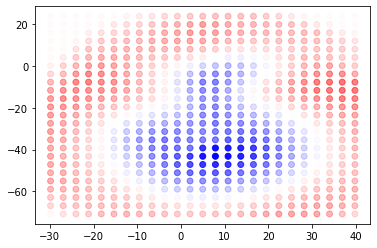

In [44]:
plot_slice(grid_vertices, grid_v_fval_arr, 5)

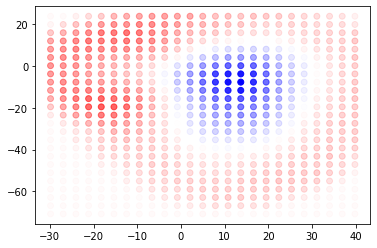

In [45]:
plot_slice(grid_vertices, grid_v_fval_arr, 14)

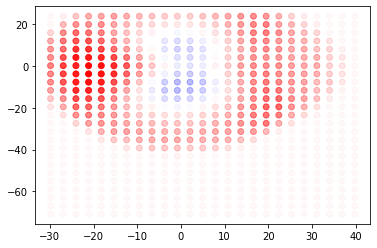

In [46]:
plot_slice(grid_vertices, grid_v_fval_arr, 22)

# Assign 2 Optional 2 - Screened Poisson Surface Reconstruction

## previous reconstruction

In [49]:
# Marcing tet to extract surface
surface_v, surface_f, _, _ = igl.marching_tets(grid_vertices, T, grid_v_fval_arr, 0)
mp.plot(surface_v, surface_f, shading={"wireframe": False})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.2914142…

 ## Screened Poisson Surface Reconstruction

In [48]:
import pymeshlab

# create a mesh from vertices and faces
m = pymeshlab.Mesh(vertices, faces)
ms = pymeshlab.MeshSet()
# add the mesh to current meshset
ms.add_mesh(m, "bunny")
# screend poisson reconstruction, only using original vertices and normals
ms.generate_surface_reconstruction_screened_poisson()
vertices_new = m.vertex_matrix()
faces_new = m.face_matrix()
mp.plot(vertices_new, faces_new, shading={"wireframe": False})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(5.0, -23.…